In [1]:
!pip install progressbar

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
import warnings

from etl.etl import Data_Correction, AttributeMapping, ratio_missing, impute_na, categorize, etl_transform, etl_save_data

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

import progressbar

# magic word for producing visualizations in notebook
%matplotlib inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 30000)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype=str)
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype=str)

azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';', dtype=str)
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';', dtype=str)

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [5]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [6]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   LNR                          object
 1   AGER_TYP                     object
 2   AKT_DAT_KL                   object
 3   ALTER_HH                     object
 4   ALTER_KIND1                  object
 5   ALTER_KIND2                  object
 6   ALTER_KIND3                  object
 7   ALTER_KIND4                  object
 8   ALTERSKATEGORIE_FEIN         object
 9   ANZ_HAUSHALTE_AKTIV          object
 10  ANZ_HH_TITEL                 object
 11  ANZ_KINDER                   object
 12  ANZ_PERSONEN                 object
 13  ANZ_STATISTISCHE_HAUSHALTE   object
 14  ANZ_TITEL                    object
 15  ARBEIT                       object
 16  BALLRAUM                     object
 17  CAMEO_DEU_2015               object
 18  CAMEO_DEUG_2015              object
 19  CAMEO_INTL_2015       

In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [8]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [9]:
customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 369 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   LNR                          object
 1   AGER_TYP                     object
 2   AKT_DAT_KL                   object
 3   ALTER_HH                     object
 4   ALTER_KIND1                  object
 5   ALTER_KIND2                  object
 6   ALTER_KIND3                  object
 7   ALTER_KIND4                  object
 8   ALTERSKATEGORIE_FEIN         object
 9   ANZ_HAUSHALTE_AKTIV          object
 10  ANZ_HH_TITEL                 object
 11  ANZ_KINDER                   object
 12  ANZ_PERSONEN                 object
 13  ANZ_STATISTISCHE_HAUSHALTE   object
 14  ANZ_TITEL                    object
 15  ARBEIT                       object
 16  BALLRAUM                     object
 17  CAMEO_DEU_2015               object
 18  CAMEO_DEUG_2015              object
 19  CAMEO_INTL_2015       

In [10]:
print('custormer dataset shape:{}'.format(customers.shape))
print('azdias dataset shape:{}'.format(azdias.shape))

custormer dataset shape:(191652, 369)
azdias dataset shape:(891221, 366)


## Cleaning

### Handling the encoded missing values

In [11]:
attr_mapping = AttributeMapping('DIAS Attributes - Values 2017.xlsx')

In [12]:
corrector = Data_Correction(attr_mapping)
irregular_values = corrector.scan_irregularities(azdias)
print(irregular_values)

{'LP_LEBENSPHASE_GROB': ['0'], 'LP_LEBENSPHASE_FEIN': ['0'], 'LP_FAMILIE_FEIN': ['0'], 'KBA05_MODTEMP': ['6'], 'ORTSGR_KLS9': ['0'], 'LP_FAMILIE_GROB': ['0'], 'CAMEO_DEU_2015': ['XX'], 'CAMEO_DEUG_2015': ['X']}


CAMEO_DEUG_2015 and CAMEO_DEU_2015 have some data 'X', 'XX' that can be considered as edge cases. These are removed manually before proceeding

In [13]:
azdias = Data_Correction.fix_edge_cases(azdias)

Doing a second pass on scanning the data for irregularities

In [14]:
irregular_values = corrector.scan_irregularities(azdias)

[========================================================================] 100%


In [15]:
irregular_values

{'LP_LEBENSPHASE_GROB': ['0'],
 'LP_LEBENSPHASE_FEIN': ['0'],
 'LP_FAMILIE_FEIN': ['0'],
 'KBA05_MODTEMP': ['6'],
 'ORTSGR_KLS9': ['0'],
 'LP_FAMILIE_GROB': ['0']}

Adding the found irregularities in the data to the unknown mapping. These will be later converted to np.nan

In [16]:
attr_mapping.add_to_unknown_mapping(irregular_values)

Decoding the missing values to np.nan

In [17]:
azdias_clean = corrector.decode_missing_values(azdias)

[========================================================================] 100%


In [18]:
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

### Feature Selection


Investigating features that are in the data but not are not mapped

In [19]:
attr_not_mapped = set(np.setdiff1d(azdias.columns, attr_mapping.defined_attributes))
print(attr_not_mapped)

{'D19_SONSTIGE', 'D19_VERSAND_REST', 'D19_BEKLEIDUNG_GEH', 'D19_NAHRUNGSERGAENZUNG', 'RT_KEIN_ANREIZ', 'ALTER_KIND3', 'EXTSEL992', 'VHA', 'D19_SCHUHE', 'MOBI_RASTER', 'CJT_TYP_4', 'D19_BILDUNG', 'D19_HAUS_DEKO', 'UMFELD_ALT', 'D19_LEBENSMITTEL', 'VHN', 'CJT_TYP_5', 'LNR', 'D19_KOSMETIK', 'VK_DISTANZ', 'D19_SOZIALES', 'KBA13_ANTG1', 'DSL_FLAG', 'D19_VOLLSORTIMENT', 'D19_LETZTER_KAUF_BRANCHE', 'KBA13_ANTG4', 'D19_VERSICHERUNGEN', 'ALTER_KIND1', 'D19_BANKEN_LOKAL', 'D19_TELKO_MOBILE', 'ANZ_STATISTISCHE_HAUSHALTE', 'VERDICHTUNGSRAUM', 'EINGEZOGENAM_HH_JAHR', 'D19_BANKEN_DIREKT', 'HH_DELTA_FLAG', 'KBA13_KMH_210', 'D19_VERSI_DATUM', 'CJT_TYP_6', 'D19_REISEN', 'D19_TIERARTIKEL', 'D19_LOTTO', 'D19_TELKO_REST', 'D19_DROGERIEARTIKEL', 'D19_DIGIT_SERV', 'D19_ENERGIE', 'D19_SAMMELARTIKEL', 'KK_KUNDENTYP', 'CJT_TYP_1', 'KBA13_ANTG3', 'RT_UEBERGROESSE', 'KBA13_BAUMAX', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_GARTEN', 'D19_BANKEN_GROSS', 'KBA13_HHZ', 'KBA13_CCM_1401_2500', 'EINGEFUEGT_AM', 'FIRMENDICHTE', 

We will remove all these features except LNR (it is a unique identifier). Even if they are in the DIAS Information Levels - Attributes 2017 file the values in the data wont be known and will not give any information on the outcomes.

In [20]:
drop_set = attr_not_mapped.copy()
drop_set.remove('LNR')

Investigating the distribution of missing values in the features

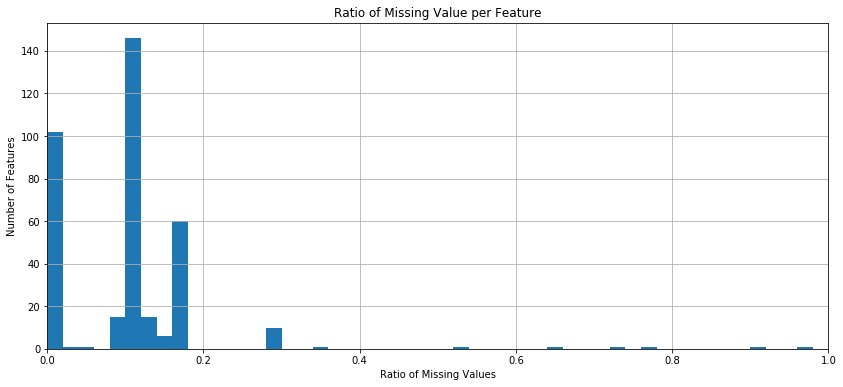

In [21]:
ratio_missing_cols = ratio_missing(azdias_clean, axis=0)

bins = np.arange(0, 1, step=0.02)
ratio_missing_cols.hist(bins=bins, figsize=(14,6))
plt.xlabel('Ratio of Missing Values')
plt.ylabel('Number of Features')
plt.title('Ratio of Missing Value per Feature')
plt.xlim((0, 1))
plt.show()

The plot shows that most of the features have below 20% missing values.

Next lets see which features have higher then 20% missing values

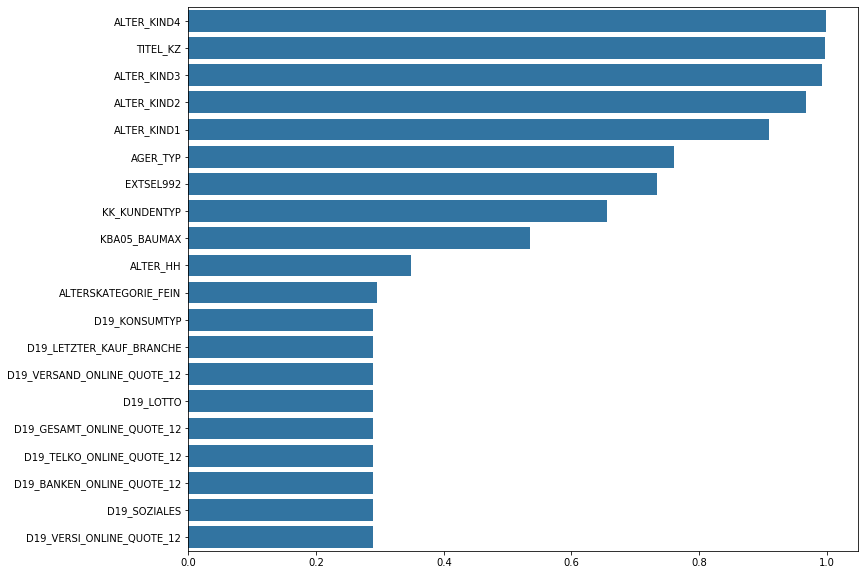

In [22]:
plt.figure(figsize=(12, 10))
base_color = sns.color_palette()[0]
above_missing_thresh = ratio_missing_cols[ratio_missing_cols>0.2]
sns.barplot(y=above_missing_thresh.index, x=above_missing_thresh, color=base_color)
plt.show()

These features will be added to the drop list.

In [23]:
drop_set = drop_set.union(above_missing_thresh.index)

### Filtering Features By Granularity

In [24]:
feature_granularity = pd.Series([len(x) for x in attr_mapping.known_mapping.values()], index=attr_mapping.known_mapping.keys()).sort_values(ascending=False)
feature_granularity.iloc[:15]

CAMEO_DEU_2015                 44
LP_LEBENSPHASE_FEIN            40
CAMEO_DEUINTL_2015             25
ALTER_HH                       21
PRAEGENDE_JUGENDJAHRE          15
GFK_URLAUBERTYP                12
LP_LEBENSPHASE_GROB            12
LP_FAMILIE_GROB                11
LP_FAMILIE_FEIN                11
D19_BANKEN_ONLINE_QUOTE_12     11
D19_VERSAND_ONLINE_QUOTE_12    11
D19_GESAMT_ONLINE_QUOTE_12     11
D19_GESAMT_DATUM               10
D19_GESAMT_ONLINE_DATUM        10
D19_VERSAND_DATUM              10
dtype: int64

Adding features with granularity higher then 10 to the drop list

In [25]:
drop_set = drop_set.union(feature_granularity[feature_granularity>10].index)

Dropping the columns

In [26]:
drop_set = azdias_clean.columns.intersection(drop_set)

In [27]:
azdias_clean.drop(drop_set, axis=1, inplace=True)
print('azdias dataset shape ',azdias_clean.shape)

azdias dataset shape  (891221, 258)


### Dealing With Missing Values

Investigating the rows

In [28]:
null_values = azdias_clean.isnull()
print('Number of rows with missing values: {}'.format(np.sum([null_values.sum(axis=1)>0])))
print('Loss ratio %.2f' % (np.sum([null_values.sum(axis=1)>0])/azdias_clean.shape[0]*100))

Number of rows with missing values: 273940
Loss ratio 30.74


If we decide on dropping the rows with null values 31% of the data will be lost. Therefore it is decided to impute the data. Imputation will be done using the median for quantitative features and most frequent for qualitative features.

Before imputing these values the data types of the features need to be assigned propperly.

In [29]:
azdias_clean = corrector.correct_data_types(azdias_clean)

Assigning float to numeric features...
Assigning string to qualitative features...


In [30]:
azdias_imputed = impute_na(azdias_clean, attr_mapping)
ref_features = azdias_imputed.columns.values

Imputing quantitative features...


[========================================================================] 100%


Imputing qualitative features...


[========================================================================] 100%


As the next step, the data will be encoded using one hot encoder for the qualitative features

In [31]:
azdias_categorized = categorize(azdias_imputed, attr_mapping)
azdias_categorized.set_index('LNR', inplace=True)

[========================================================================] 100%


The data will be scaled using standardization

In [32]:
# Training the scaler
scaler = StandardScaler()
scaler.fit(azdias_categorized)
azdias_scaled_df = pd.DataFrame(scaler.transform(azdias_categorized), columns = azdias_categorized.columns.values, index=azdias_categorized.index)

Going through the same process for the customers dataset

In [33]:
customers_scaled_df = etl_transform(customers, attr_mapping, ref_features, scaler)

Correcting issues on edge cases...


Checking for irregular values...


[========================================================================] 100%


Decoding missing or unknown values as NaN...


[========================================================================] 100%


getting the subset of the data with the reference features...
Correcting data types...
Assigning float to numeric features...
Assigning string to qualitative features...


Imputing missing values...
Imputing quantitative features...


[========================================================================] 100%


Imputing qualitative features...


[========================================================================] 100%


OneHot Encoding data...


[========================================================================] 100%


Scaling data...
Finishing.


### Saving the Output

In [34]:
print('Saving azdias_categorized')
azdias_categorized.to_csv('azdiaz_categorized.csv')
print('Saving azdias_scaled_df')
azdias_scaled_df.to_csv('azdias_scaled_df.csv')
print('Saving customers_scaled_df')
customers_scaled_df.to_csv('customers_scaled_df.csv')

print('Saving attr_mapping')
with open('attr_mapping.pkl', 'wb') as file:
    pickle.dump(attr_mapping, file, protocol=pickle.HIGHEST_PROTOCOL)

print('Saving ref_features')
with open('ref_features.pkl', 'wb') as file:
    pickle.dump(ref_features, file, protocol=pickle.HIGHEST_PROTOCOL)

print('Saving scaler')
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file, protocol=pickle.HIGHEST_PROTOCOL)

Saving azdias_categorized
Saving azdias_scaled_df
Saving customers_scaled_df
Saving attr_mapping
Saving ref_features
Saving scaler


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [88]:
azdias_preprocessed = pd.read_csv('azdias_scaled_df.csv', index_col='LNR')
customers_preprocessed = pd.read_csv('customers_scaled_df.csv', index_col='LNR')

### Dimentionality Redution

In [40]:
pca = PCA(azdias_preprocessed.shape[1], random_state=73)
print('Fitting PCA')
pca.fit(azdias_preprocessed)

Fitting PCA


PCA(copy=True, iterated_power='auto', n_components=308, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

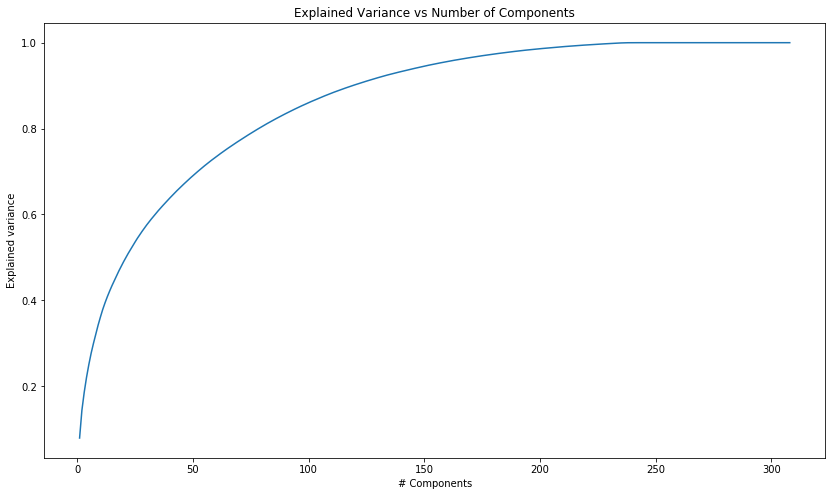

In [41]:
explained_var = np.cumsum(pca.explained_variance_ratio_)
index = np.arange(1, len(explained_var)+1)

plt.figure(figsize=(14, 8))
plt.plot(index, explained_var)
plt.xlabel('# Components')
plt.ylabel('Explained variance')
plt.title('Explained Variance vs Number of Components')
plt.show()

Zooming in to the range 0 - 200 features

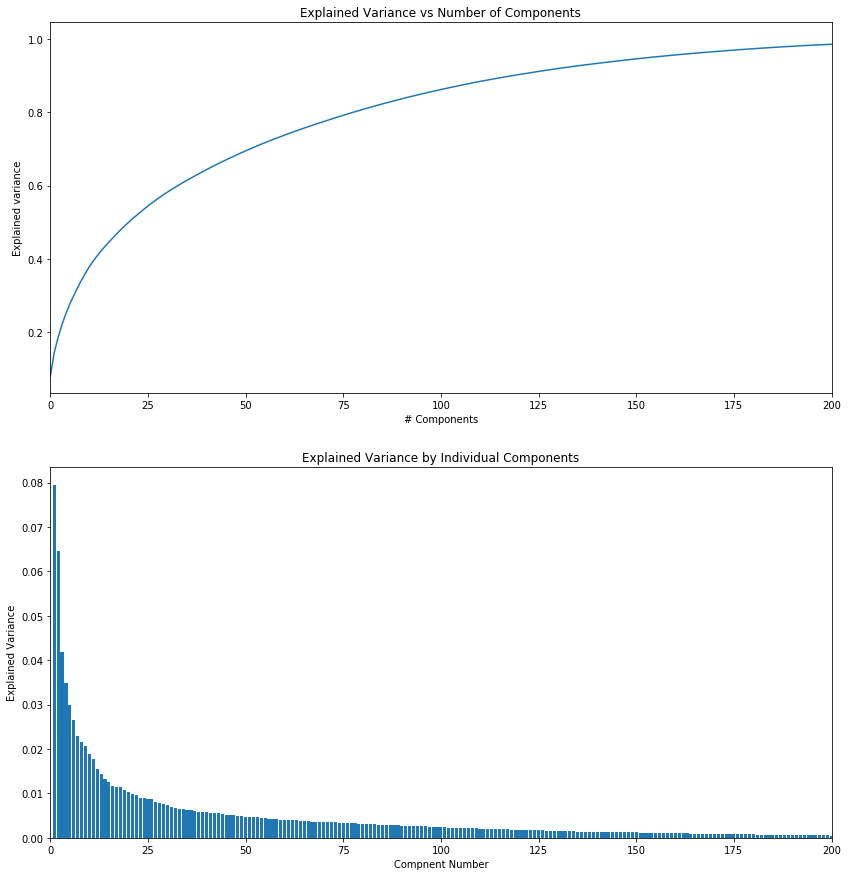

In [43]:
plt.figure(figsize=(14,15))
plt.subplot(2,1,1)
plt.plot(explained_var)
plt.xlim((0,200))
plt.xlabel('# Components')
plt.ylabel('Explained variance')
plt.title('Explained Variance vs Number of Components')

plt.subplot(2,1,2)
plt.bar(index, pca.explained_variance_ratio_)
plt.xlabel('Compnent Number')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Individual Components')
plt.xlim((0,200))
plt.show()

In [48]:
print(explained_var[119])

0.901859612570835


The first 120 components are chosen. These components explain 92% of the variation

In [49]:
n_selected = 120

pca_selected = PCA(n_selected, random_state=73)
print('Fitting PCA')
pca_selected.fit(azdias_preprocessed)

Fitting PCA


PCA(copy=True, iterated_power='auto', n_components=120, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [51]:
print('Variance explainable by the PCA is %.2f ' % (sum(pca_selected.explained_variance_ratio_)*100))

Variance explainable by the PCA is 90.10 


Transforming the data with the trained pca object

In [92]:
pca_columns = ['PC_{}'.format(i) for i in range(1, n_selected+1)]
azdias_reduced = pd.DataFrame(pca_selected.transform(azdias_preprocessed), columns=pca_columns, index=azdias_preprocessed.index)
customers_reduced = pd.DataFrame(pca_selected.transform(customers_preprocessed), columns=pca_columns, index=customers_preprocessed.index)

### Saving Trained PCA Object

In [53]:
# Saving the pca object before proceeding
with open('pca_selected.pkl', 'wb') as file:
    pickle.dump(pca_selected, file, protocol=pickle.HIGHEST_PROTOCOL)

### Clustering

In [54]:
n_clusters = 50
cnter = 0
bar = progressbar.ProgressBar(maxval=n_clusters+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

score = []
clusters = np.arange(2, n_clusters+1)
for i in clusters:
    k_means = MiniBatchKMeans(n_clusters=i, batch_size=5000)
    cluster = k_means.fit(azdias_reduced)
    score.append(cluster.score(azdias_reduced))
    cnter+=1 
    bar.update(cnter)
    
bar.finish()

[========================================================================] 100%


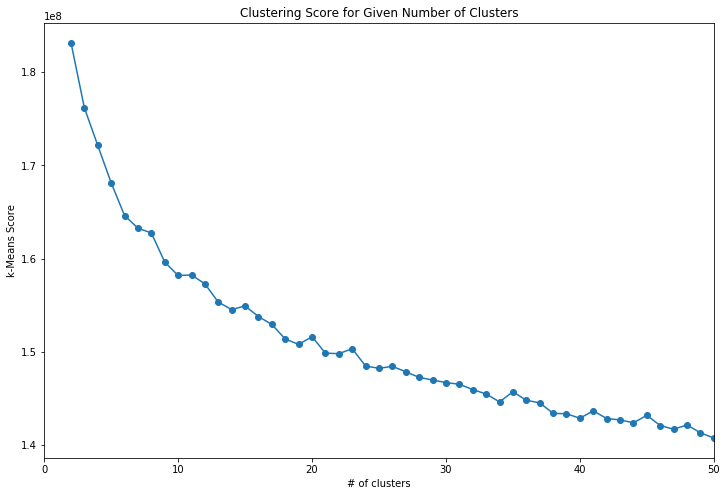

In [55]:
plt.figure(figsize=(12,8))
plt.plot(clusters, np.absolute(score), marker='o')
plt.xlabel('# of clusters');
plt.ylabel('k-Means Score');
plt.title('Clustering Score for Given Number of Clusters');
plt.xlim((0,n_clusters));

Above plot shows that there is not much change after 25 clusters there for for the clustering model 25 is selected as the number of clusters.

In [59]:
n_selected_cluster = 25
k_means_selected = MiniBatchKMeans(n_clusters=n_selected_cluster, batch_size=5000)
k_means_selected.fit(azdias_reduced) # clustering azdias data with selected number of clusters

MiniBatchKMeans(batch_size=5000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=25, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [93]:
azdias_clusters = k_means_selected.predict(azdias_reduced) # clustering azdias data with selected number of clusters
customers_clusters = k_means_selected.predict(customers_reduced) # clustering customers data with the trained clusterer

In [95]:
azdias_reduced['Cluster'] = azdias_clusters
customers_reduced['Cluster'] = customers_clusters

Saving the output

In [98]:
print('Saving clustered results for azdias_reduced')
azdias_reduced.to_csv('azdias_reduced.csv')
print('Saving clustered results for customers_reduced')
customers_reduced.to_csv('customers_reduced.csv')

print('Saving trained K_means object')
with open('k_means_selected.pkl', 'wb') as file:
    pickle.dump(k_means_selected, file, protocol=pickle.HIGHEST_PROTOCOL)

Saving clustered results for azdias_reduced
Saving clustered results for customers_reduced
Saving trained K_means object


### Investigating The Results

In [99]:
azdias_cluster_ratio = azdias_reduced['Cluster'].value_counts()/azdias_reduced.shape[0]
customers_cluster_ratio = customers_reduced['Cluster'].value_counts()/customers_reduced.shape[0]

ratios_df = pd.DataFrame({'azdias':azdias_cluster_ratio, 'customers':customers_cluster_ratio})

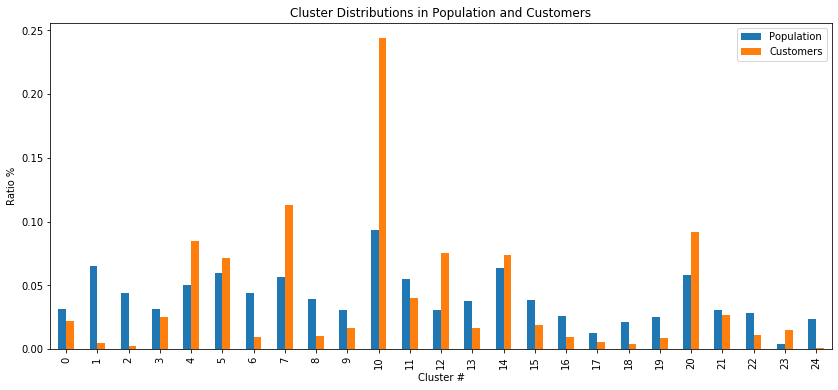

In [100]:
ratios_df.plot(kind='bar', figsize=(14,6))
plt.legend(('Population', 'Customers'));
plt.title(('Cluster Distributions in Population and Customers'));
plt.xlabel('Cluster #');
plt.ylabel('Ratio %');
plt.show()

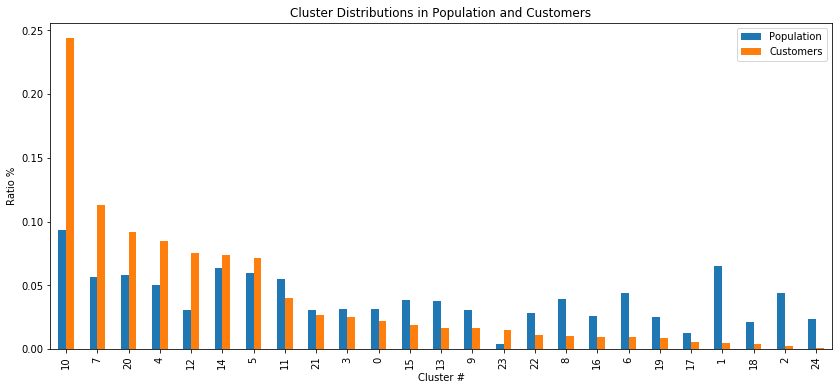

In [101]:
ratios_df.sort_values('customers', ascending=False).plot(kind='bar', figsize=(14,6))
plt.legend(('Population', 'Customers'));
plt.title(('Cluster Distributions in Population and Customers'));
plt.xlabel('Cluster #');
plt.ylabel('Ratio %');
plt.show()

Customers are mostly defined by the cluster 10. Afterwards this cluster is followed by 7, 20, 4, 12, 14 and 5.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=str)

mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype=str)

In [3]:
target = mailout_train[['LNR', 'RESPONSE']]
target.set_index('LNR', inplace=True)
target = target.astype(float)

In [7]:
with open('ref_features.pkl', 'rb') as f:
    ref_features = pickle.load(f)
    
with open('attr_mapping.pkl', 'rb') as f:
    attr_mapping = pickle.load(f)

Cleaning the training data

In [8]:
mailout_train_cleaned = etl_transform(mailout_train, attr_mapping, ref_features, scaler=None, apply_scaler=False)

Correcting issues on edge cases...


Checking for irregular values...


[========================================================================] 100%


Decoding missing or unknown values as NaN...


[========================================================================] 100%


getting the subset of the data with the reference features...
Correcting data types...
Assigning float to numeric features...
Assigning string to qualitative features...


Imputing missing values...
Imputing quantitative features...


[========================================================================] 100%
[========================================================================] 100%


Imputing qualitative features...
OneHot Encoding data...


Finishing.


Applying a test-train split on the data

In [9]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_cleaned, target, stratify=target, test_size=0.2)

In [10]:
y_train_0 = y_train[y_train['RESPONSE']==0].sample(y_train[y_train['RESPONSE']==1].shape[0]*1)
y_train_1 = y_train[y_train['RESPONSE']==1]
y_train_modified = pd.concat([y_train_0, y_train_1])
X_train_modified = X_train.loc[y_train_modified.index]

In [11]:
y_train[y_train['RESPONSE']=='1']

,RESPONSE
LNR,


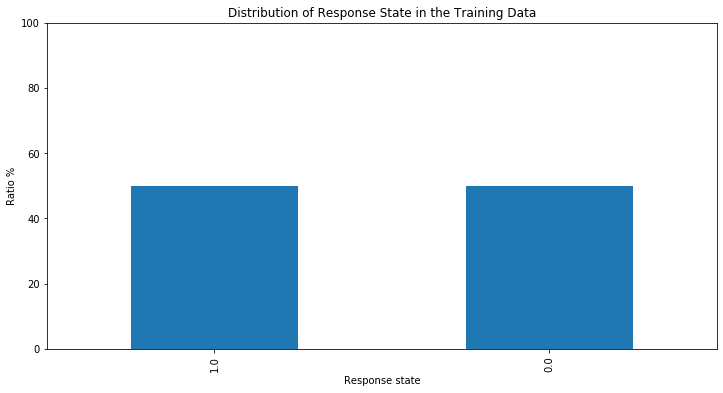

In [12]:
(y_train_modified['RESPONSE'].value_counts()/y_train_modified['RESPONSE'].shape[0]*100).plot(kind='bar', figsize=(12,6))
plt.ylim((0, 100))
plt.xlabel('Response state')
plt.ylabel('Ratio %')
plt.title('Distribution of Response State in the Training Data')
plt.show()

Creating the Supervised Learning pipeline

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(750)),
    ('clf', GradientBoostingClassifier())
    ])

In [14]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=750, random_state=None,
       svd_solver='auto', tol=0.0, whiten=False)),
  ('clf',
   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                              learning_rate=0.1, loss='deviance', max_depth=3,
                              max_features=None, max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_iter_no_change=None, presort='deprecated',
                              random_state=None, subsample=1.0, tol=0.0001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
 'verbose': False,
 

In [15]:
parameters = {
        'pca__n_components': [100, 150, 200],
        'clf__n_estimators': [500, 750, 1000],
        'clf__max_depth': [3, 4]
        }
    
model = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1, verbose=10, cv=5)
model.fit(X_train_modified, y_train_modified.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:  4.9min remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=750, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('clf',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                      

In [16]:
print(model.best_params_)

{'clf__max_depth': 3, 'clf__n_estimators': 500, 'pca__n_components': 100}


### Testing the Model

In [17]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

confusion_mat = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(confusion_mat, index=[0, 1], columns=[0, 1])

              precision    recall  f1-score   support

         0.0       0.99      0.55      0.71      8487
         1.0       0.01      0.47      0.03       106

    accuracy                           0.55      8593
   macro avg       0.50      0.51      0.37      8593
weighted avg       0.98      0.55      0.70      8593



In [18]:
df_cm

,0,1
0,4699,3788
1,56,50


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [30]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=str)

mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype=str)

In [31]:
mailout_test_cleaned = etl_transform(mailout_test, attr_mapping, ref_features, scaler=None, apply_scaler=False)

Correcting issues on edge cases...


Checking for irregular values...


[========================================================================] 100%


Decoding missing or unknown values as NaN...


[========================================================================] 100%


getting the subset of the data with the reference features...
Correcting data types...
Assigning float to numeric features...
Assigning string to qualitative features...


Imputing missing values...
Imputing quantitative features...


[========================================================================] 100%
[========================================================================] 100%


Imputing qualitative features...
OneHot Encoding data...


Finishing.


In [32]:
y_pred = model.predict(mailout_test_cleaned)

In [33]:
mailout_test_predicted = pd.DataFrame({'LNR':mailout_test_cleaned.index, 'RESPONSE':y_pred})

In [34]:
mailout_test_predicted.to_csv('mailout_test_predicted.csv', index=False)

Submission to Kaggle got a score of 0.51736